In [471]:
# Importações
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from scipy import stats

# Relatório de Análise Meteorológica: Bacias do Rio das Velhas

**1. Identificação e conhecimento da fonte primária:**

* A fonte primária de dados explorada neste relatório são as informações relacionadas à precipitação total mensal. Esses dados são provenientes das estações localizadas nas proximidades das bacias do Rio das Velhas, obtidos através do INMET.


**2. Proposta de Investigação:**
* Considerando a relevância crítica da água nas bacias do Rio das Velhas e a influência direta da precipitação nas condições hidrológicas, propomos uma investigação para analisar a relação entre as precipitações e as vazões nessa região.

**2. Variável Meteorológica Escolhida:**
* A variável escolhida para análise é a precipitação total mensal.

**4. Seleção de Estações:**
* Foram selecionadas dez estações próximas entre si ou contidas em uma mesma região delimitada. As estações escolhidas são: CONTAGEM, BELO HORIZONTE (PAMPULHA), DIAMANTINA, CURVELO, PIRAPORA, SETE LAGOAS, BELO HORIZONTE - CERCADINHO, JABOTICATUBAS, RIO-ACIMA, SANTA-LUZIA, E VESPASIANO.

**5. Período de Análise:**
A coleta, organização e filtragem dos dados foram realizadas para o período de 2018 a 2022.

In [472]:
def reader_one(file_path):
    header_start = 0
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if 'Latitude:' in line:
                latitude = float(line.split(':')[1].strip())
            elif 'Longitude:' in line:
                longitude = float(line.split(':')[1].strip())
            if 'Data Medicao;PRECIPITACAO TOTAL, MENSAL (AUT)(mm);' in line:
                header_start = i
                break
    
    df = pd.read_csv(file_path, delimiter=';', skiprows=header_start, usecols=['Data Medicao', 'PRECIPITACAO TOTAL, MENSAL (AUT)(mm)'])
    df = df.rename(columns={'PRECIPITACAO TOTAL, MENSAL (AUT)(mm)': 'valorMedida'})
    df = df.rename(columns={'Data Medicao': 'DataMedicao'})
    df['latitude'] = latitude
    df['longitude'] = longitude
    
    return df

def reader_two(file_path):    
    df = pd.read_csv(file_path)    
    df = df[['data', 'valorMedida', 'latitude', 'longitude']]
    df['data'] = pd.to_datetime(df['data'] + '-01')  # Adiciona '-01' para garantir o primeiro dia do mês
    df['data'] = df['data'] + pd.offsets.MonthEnd(0)  # Converte para o último dia do mês
    df = df.rename(columns={'data': 'DataMedicao'})

    return df

def filter_dates_station(station_data):
    for city, data in station_data.items():
        station_data[city]['DataMedicao'] = pd.to_datetime(station_data[city]['DataMedicao'], errors='coerce', format='%Y-%m-%d') 
        station_data[city] = station_data[city][station_data[city]['DataMedicao'].dt.year.between(2018, 2022)]
        if station_data[city].loc[:, 'valorMedida'].dtype != float:
            station_data[city].loc[:, 'valorMedida'] = ( station_data[city]['valorMedida'].str.replace(',', '.').astype(float))
    
    return station_data
    

In [473]:
data_paths = {0: 'dados/dados_A521_M_2006-10-09_2022-12-31.csv',              
              1: 'dados/dados_A537_M_2007-06-04_2022-12-31.csv',
              2: 'dados/dados_A538_M_2006-12-17_2022-12-31.csv',
              3: 'dados/dados_A545_M_2007-07-03_2022-12-31.csv',
              4: 'dados/dados_A569_M_2016-06-09_2022-12-31.csv',
              5: 'dados/dados_F501_M_2013-12-26_2022-12-31.csv',
              6: 'dados/jaboticatubas-centro.csv',
              7: 'dados/Rio-Acima-Morgans.csv',
              8: 'dados/Santa Luzia-Palmital.csv',
              9: 'dados/vespasiano-santaonies.csv',
              10: 'dados/Ouro Preto-Bauxita.csv'}
            
station = ['BH-PAMPULHA',
           'DIAMANTINA',
           'CURVELO',
           'PIRAPORA',
           'SETE-LAGOAS',
           'BH-CERCADINHO',
           'JABOTICATUBAS',
           'RIO-ACIMA',
           'SANTA-LUZIA',
           'VESPASIANO',
           'OURO-PRETO']


station_data = {}
for key, path in data_paths.items():
    if key < 6:
        station_data[station[key]] = reader_one(path)
    else:
        station_data[station[key]] = reader_two(path)


station_data = filter_dates_station(station_data)

**6. Importar os dados para tabelas geográficas, em que a localização da estação possa ser usada.**

Foi implementada a importação dos dados para tabelas geográficas visando a utilização eficiente da localização das estações meteorológicas. Foram criadas duas tabelas distintas: "weather_stations" e "rainfall_data". A primeira tabela contém informações detalhadas sobre cada estação empregada no estudo, enquanto a segunda tabela armazena os dados pluviométricos, sendo referenciada pelo identificador único da estação correspondente.

In [474]:
list_stations_city = []
list_stations_data = []
count = 0
for city, data in station_data.items():

    # substituindo os valores nulos pela media
    media = data['valorMedida'].mean()
    data['valorMedida'].fillna(media, inplace=True)  

    station = {}
    station['id_estacao'] = count
    station['estacao'] = city 
    station['max_pluv'] = data['valorMedida'].max()
    filtro_nao_zero = data['valorMedida'] != 0
    station['min_pluv'] = data.loc[filtro_nao_zero, 'valorMedida'].min()
    station['media_anual_pluv'] = data['valorMedida'].mean().round(2)
    # Filtrar dados para incluir apenas os meses de outubro a março
    filtro_outubro_marco = (data['DataMedicao'].dt.month >= 10) | (data['DataMedicao'].dt.month <= 3)
    dados_outubro_marco = data[filtro_outubro_marco]    
    station['media_prec_pluv'] = dados_outubro_marco['valorMedida'].mean().round(2)
    # Filtrar dados para incluir apenas os meses de abril a setembro
    filtro_outubro_marco = (data['DataMedicao'].dt.month >= 4) | (data['DataMedicao'].dt.month <= 9)
    dados_outubro_marco = data[filtro_outubro_marco]    
    station['media_est_pluv'] = dados_outubro_marco['valorMedida'].mean().round(2)
    station['desvio_pluv'] = data['valorMedida'].std().round(2)
    station['latitude'] = data['latitude'].iloc[0]
    station['longitude'] = data['longitude'].iloc[0]
    list_stations_city.append(station)

    data['id_estacao_fk'] = count
    data.drop('latitude', axis=1, inplace=True)
    data.drop('longitude', axis=1, inplace=True)
    list_stations_data.append(data)
    count += 1

df_stations = pd.DataFrame(list_stations_city)
df_stations.to_csv('tabelas_geograficas/weather_stations.csv', index=False)
display(df_stations)
    

,id_estacao,estacao,max_pluv,min_pluv,media_anual_pluv,media_prec_pluv,media_est_pluv,desvio_pluv,latitude,longitude
0,0,BH-PAMPULHA,739.80,0.4,137.12,248.03,137.12,151.62,-19.883889,-43.969444
1,1,DIAMANTINA,581.80,0.2,117.33,201.24,117.33,125.37,-18.231052,-43.648269
2,2,CURVELO,416.00,0.2,100.01,169.67,100.01,109.55,-18.747711,-44.453785
3,3,PIRAPORA,402.20,0.8,90.32,166.69,90.32,99.77,-17.258064,-44.835556
4,4,SETE-LAGOAS,595.00,0.2,128.79,219.23,128.79,135.96,-19.455278,-44.173333
5,5,BH-CERCADINHO,966.60,0.4,153.08,278.82,153.08,184.18,-19.980000,-43.958611
6,6,JABOTICATUBAS,413.00,0.2,103.91,200.73,103.91,123.49,-19.517010,-43.745180
7,7,RIO-ACIMA,611.80,0.2,114.05,207.99,114.05,136.66,-20.087600,-43.785103
8,8,SANTA-LUZIA,519.00,0.2,116.34,221.94,116.34,137.86,-19.766250,-43.835350
9,9,VESPASIANO,483.40,0.2,82.03,150.43,82.03,107.88,-19.758210,-43.953920


In [475]:
df_rainfall = pd.concat(list_stations_data, ignore_index=True)
df_rainfall.to_csv('tabelas_geograficas/rainfall_data.csv', index=False)
display(df_rainfall)

,DataMedicao,valorMedida,id_estacao_fk
0,2018-01-31,183.80,0
1,2018-02-28,284.20,0
2,2018-03-31,368.00,0
3,2018-04-30,13.20,0
4,2018-05-31,11.40,0
...,...,...,...
646,2022-08-31,0.80,10
647,2022-09-30,23.35,10
648,2022-10-31,179.88,10
649,2022-11-30,335.51,10


**7. Análise e Hipótese: Investigação da Relação entre a Vazão do Rio das Velhas e a Intensidade de Precipitação Anual**

* Nossa hipótese central é que a vazão do Rio das Velhas está diretamente proporcional à intensidade anual de precipitação. A suposição é que anos com maiores índices de precipitação resultarão em vazões mais elevadas, enquanto anos de menor precipitação estarão associados a uma vazão reduzida.

* Os dados de vazão do Rio das Velhas foram registrados e armazenados na tabela denominada 'monthly_flow_rio_das_velhas'. Essa tabela servirá como base para a análise proposta.


In [476]:
# Importando dados de vazão do Rio das Velhas no período de 2018 a 2022

def reader_three(file_path):
    desired_columns = ['Ano', 'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    df = pd.read_csv(file_path, delimiter=';')
    return df[desired_columns]



df_river_flow = reader_three('dados/monthly_flow_rio_das_velhas.csv')
df_river_flow = df_river_flow[(df_river_flow['Ano']>= 2018) & (df_river_flow['Ano']<= 2022)]
display(df_river_flow)

,Ano,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
47,2018,18.663,38.522,39.725,20.997,14.514,13.612,12.866,14.787,13.949,14.584,22.819,23.846
48,2019,19.864,21.797,17.460,23.921,17.652,13.438,12.269,10.313,9.983,11.281,21.241,25.095
49,2020,88.723,54.977,62.973,22.945,17.203,14.553,11.655,12.333,10.915,12.737,20.219,16.951
50,2021,16.845,31.918,23.019,15.746,12.581,11.320,10.957,10.317,10.371,20.628,33.306,32.312
51,2022,120.849,65.922,28.684,20.311,18.311,13.973,NaN,NaN,NaN,NaN,NaN,NaN


**8. Quantidade de dados válidos disponíveis em cada estação por coluna**

* Observa-se que, para a coluna 'DataMedicao', todas as estações, incluindo BH-PAMPULHA, DIAMANTINA, CURVELO, PIRAPORA, SETE-LAGOAS, BH-CERCADINHO, JABOTICATUBAS, RIO-ACIMA, SANTA-LUZIA e VESPASIANO, possuem 60 registros válidos. No entanto, ao analisar a coluna 'valorMedida', observa-se variações no número de registros válidos, indicando a possibilidade de dados ausentes ou não registrados em algumas estações. Essas discrepâncias podem influenciar diretamente as análises estatísticas e modelagem, destacando a importância de uma abordagem cuidadosa ao lidar com dados faltantes ou inconsistentes durante o processo de análise.

In [477]:
df_count = pd.DataFrame({city: df.count() for city, df in station_data.items()})
display(df_count)

,BH-PAMPULHA,DIAMANTINA,CURVELO,PIRAPORA,SETE-LAGOAS,BH-CERCADINHO,JABOTICATUBAS,RIO-ACIMA,SANTA-LUZIA,VESPASIANO,OURO-PRETO
DataMedicao,60,60,60,60,60,60,58,58,58,57,60
valorMedida,60,60,60,60,60,60,58,58,58,57,60
id_estacao_fk,60,60,60,60,60,60,58,58,58,57,60


**9. Reconstrução de um dicionário de dados**

In [478]:
import pandas as pd

def data_dictionary(df):
    dic_dados = {}

    for coluna in df.columns:
        dic_coluna = {}

        # Descrição da coluna
        if coluna == 'DataMedicao':
            dic_coluna['Descricao'] = f'A data da medição da precipitação refere-se ao último dia do mês, pois a medição representa a média mensal da precipitação diária.'
        elif coluna == 'valorMedida':
            dic_coluna['Descricao'] = f'Trata-se da medição da PRECIPITAÇÃO TOTAL MENSAL (AUT) em milímetros.'
        elif coluna == 'id_estacao_fk':
            dic_coluna['Descricao'] = f'Representa a chave estrageira do id das estações meteorologicas.'
        elif coluna == 'latitude':
            dic_coluna['Descricao'] = f'Representa a coordenada geográfica de latitude.'
        elif coluna == 'longitude':
            dic_coluna['Descricao'] = f'Representa a coordenada geográfica de longitude.'
        elif coluna == 'id_estacao':
            dic_coluna['Descricao'] = f'Representa o id da estação meteorologica.'
        elif coluna == 'estacao':
            dic_coluna['Descricao'] = f'Representa o nome da estação meteorologica.'
        elif coluna == 'max_pluv':
            dic_coluna['Descricao'] = f'Representa maior valor das precipitações medidas naquela estação meteorologica.'
        elif coluna == 'min_pluv':
            dic_coluna['Descricao'] = f'Representa menor valor das precipitações medidas naquela estação meteorologica.'
        elif coluna == 'media_anual_pluv':
            dic_coluna['Descricao'] = f'Representa a media anual das precipitações medidas naquela estação meteorologica.'
        elif coluna == 'media_prec_pluv':
            dic_coluna['Descricao'] = f'Representa a media no periodo de precipitação das precipitações medidas naquela estação meteorologica.'
        elif coluna == 'media_est_pluv':
            dic_coluna['Descricao'] = f'Representa a media no periodo de estiagem das precipitações medidas naquela estação meteorologica.'
        elif coluna == 'desvio_pluv':
            dic_coluna['Descricao'] = f'Representa o desvio padrao medidas das precipitações anuais medidas naquela estação meteorologica.'
            
        

        # Tipo de Dados
        tipo_dados = str(df[coluna].dtype)
        dic_coluna['Tipo de Dados'] = tipo_dados

        # Quantidade de Valores Únicos
        qtd_valores_unicos = df[coluna].nunique()
        dic_coluna['Quantidade de Valores Únicos'] = qtd_valores_unicos

        # Quantidade Total de Valores
        qtd_valores_totais = len(df[coluna])
        dic_coluna['Quantidade Total de Valores'] = qtd_valores_totais

        dic_dados[coluna] = dic_coluna

    # Remover a chave 'Cidade' do dicionário, pois ela não representa uma coluna no DataFrame
    dic_dados.pop('Cidade', None)

    # Criar DataFrame a partir do dicionário
    df_cidade = pd.DataFrame.from_dict(dic_dados, orient='index')

    return df_cidade

# Criar DataFrames para cada cidade
dataframes_cidades = {}


dic_df_rainfall = data_dictionary(df_rainfall)
display(dic_df_rainfall)
dic_df_wearther_stations = data_dictionary(df_stations)
display(dic_df_wearther_stations)



,Descricao,Tipo de Dados,Quantidade de Valores Únicos,Quantidade Total de Valores
DataMedicao,A data da medição da precipitação refere-se ao...,datetime64[ns],60,651
valorMedida,Trata-se da medição da PRECIPITAÇÃO TOTAL MENS...,float64,446,651
id_estacao_fk,Representa a chave estrageira do id das estaçõ...,int64,11,651


,Descricao,Tipo de Dados,Quantidade de Valores Únicos,Quantidade Total de Valores
id_estacao,Representa o id da estação meteorologica.,int64,11,11
estacao,Representa o nome da estação meteorologica.,object,11,11
max_pluv,Representa maior valor das precipitações medid...,float64,11,11
min_pluv,Representa menor valor das precipitações medid...,float64,3,11
media_anual_pluv,Representa a media anual das precipitações med...,float64,11,11
media_prec_pluv,Representa a media no periodo de precipitação ...,float64,11,11
media_est_pluv,Representa a media no periodo de estiagem das ...,float64,11,11
desvio_pluv,Representa o desvio padrao medidas das precipi...,float64,11,11
latitude,Representa a coordenada geográfica de latitude.,float64,11,11
longitude,Representa a coordenada geográfica de longitude.,float64,11,11


## Visualizações

**Evolução da Precipitação - Todas as estações**

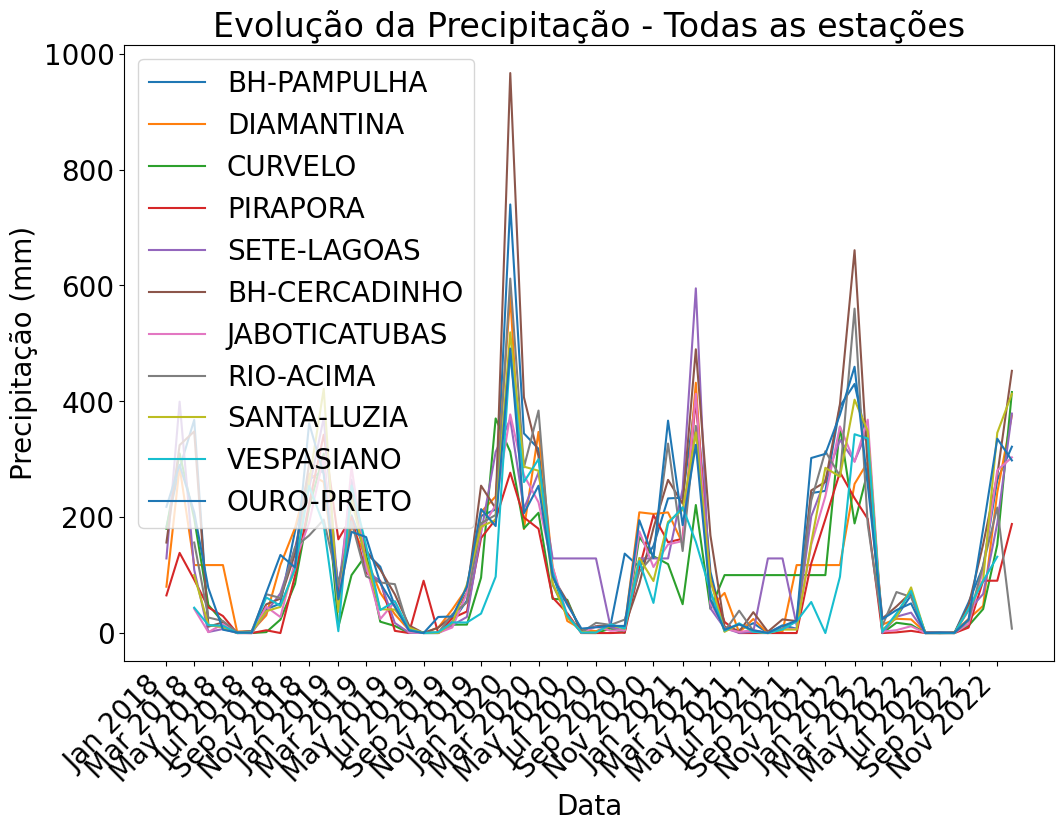

In [479]:
def plot_stations(station_data):    
    plt.figure(figsize=(12, 8))
    for cidade, df in station_data.items():                
        plt.plot(df['DataMedicao'], df['valorMedida'], label=cidade)
    
    plt.title('Evolução da Precipitação - Todas as estações')
    plt.xlabel('Data')
    plt.ylabel('Precipitação (mm)')
    plt.legend()     
    plt.xticks(df['DataMedicao'][::2], df['DataMedicao'][::2].dt.strftime('%b %Y'), rotation=45, ha='right')
    plt.show()


def plot_stations_bars(station_data):    
    plt.figure(figsize=(12, 8))
    
    for cidade, df in station_data.items():                
        plt.bar(df['DataMedicao'], df['valorMedida'], label=cidade, alpha=0.7)
    
    plt.title('Evolução da Precipitação - Todas as estações')
    plt.xlabel('Data')
    plt.ylabel('Precipitação (mm)')
    plt.legend()     
    plt.xticks(rotation=90, ha='right')
    plt.show()

def plot_stations_multibars(station_data):    
    fig, axs = plt.subplots(len(station_data), 1, figsize=(12, 32), sharex=True, sharey=True)

    for (cidade, df), ax in zip(station_data.items(), axs):                
        ax.bar(df['DataMedicao'], df['valorMedida'], alpha=0.7)
        ax.set_title(f'Evolução da Precipitação - {cidade}')
        ax.set_ylabel('Precipitação (mm)')

    plt.xlabel('Data')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()


plot_stations(station_data)

**Série temporal para representar a pluviosidade (mm) e a vazão (m³/s) ao longo do tempo para cada estação meteorológica e para o Rio das Velhas.**

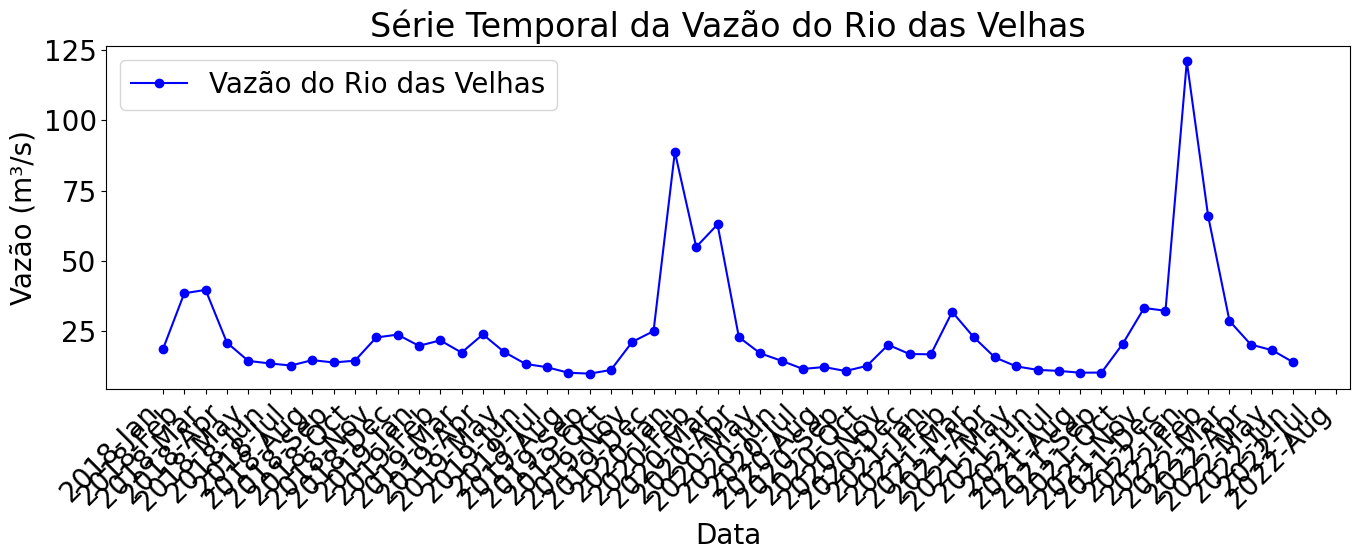

In [480]:
df_river_flow_melted = df_river_flow.melt(id_vars=['Ano'], var_name='Mes', value_name='Vazao')

meses_pt_to_en = {
    'Jan': 'Jan',
    'Fev': 'Feb',
    'Mar': 'Mar',
    'Abr': 'Apr',
    'Mai': 'May',
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Ago': 'Aug',
    'Set': 'Sep',
    'Out': 'Oct',
    'Nov': 'Nov',
    'Dez': 'Dec'
}

df_river_flow_melted['Mes'] = df_river_flow_melted['Mes'].map(meses_pt_to_en)
df_river_flow_melted['Data'] = df_river_flow_melted.apply(lambda row: datetime.strptime(str(row['Ano']) + '-' + row['Mes'], "%Y-%b"), axis=1)
df_river_flow_melted = df_river_flow_melted.sort_values(by='Data', ascending=True)
df_river_flow_melted['Data'] = df_river_flow_melted['Data'].dt.to_period('M')
df_river_flow_melted['Data'] = df_river_flow_melted['Data'].dt.strftime("%Y-%b")

colunas_a_apagar = ['Ano', 'Mes']

for coluna in colunas_a_apagar:
    if coluna in df_river_flow_melted.columns:
        df_river_flow_melted = df_river_flow_melted.drop(columns=[coluna])

if 'Data' in df_river_flow_melted.columns:
    colunas_ordenadas = ['Data'] + [coluna for coluna in df_river_flow_melted.columns if coluna != 'Data']
    df_river_flow_melted = df_river_flow_melted[colunas_ordenadas]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_river_flow_melted['Data'], df_river_flow_melted['Vazao'], marker='o', linestyle='-', color='b', label='Vazão do Rio das Velhas')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Série Temporal da Vazão do Rio das Velhas')
plt.legend()
plt.tight_layout()
plt.show()


**Grafico comparativo da vazão do rio e da precipitação ao longo dos anos**

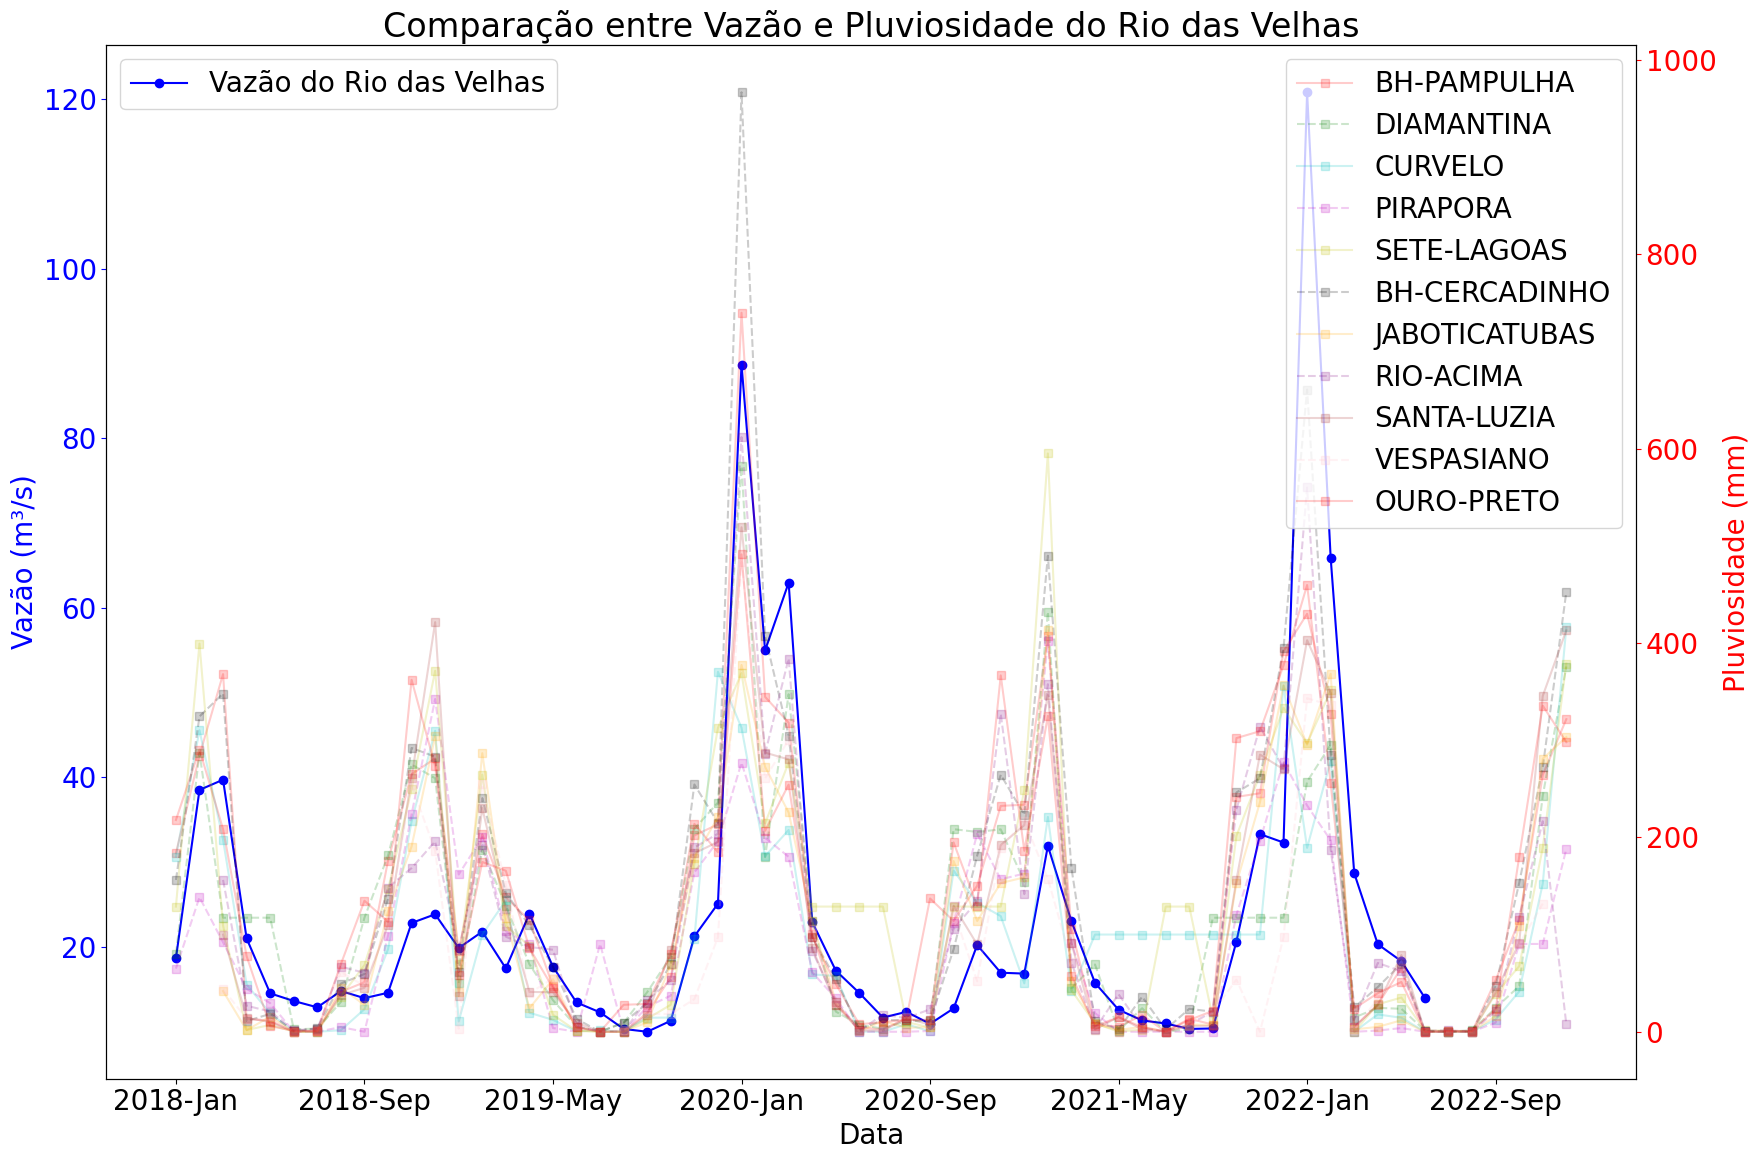

In [481]:
for city, data in station_data.items():
    data['DataMedicao'] = pd.to_datetime(data['DataMedicao'], format='%Y-%b')    
    data['DataMedicao'] = data['DataMedicao'].dt.strftime('%Y-%b')

fig, ax1 = plt.subplots(figsize=(18, 12))


ax1.plot(df_river_flow_melted['Data'], df_river_flow_melted['Vazao'], marker='o', linestyle='-', color='b', label='Vazão do Rio das Velhas')
ax1.set_xlabel('Data')
ax1.set_ylabel('Vazão (m³/s)', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink']
alpha = 0.2

for i, (city, data) in enumerate(station_data.items()):    
    color = colors[i % len(colors)]        
    linestyle = '-' if i % 2 == 0 else '--'        
    ax2.plot(data['DataMedicao'], data['valorMedida'], marker='s', linestyle=linestyle, color=color, alpha=alpha, label=f'{city}')
    ax2.set_ylabel('Pluviosidade (mm)', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 20})
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))  # Ajustar o número de rótulos visíveis
plt.title('Comparação entre Vazão e Pluviosidade do Rio das Velhas')
plt.tight_layout()
plt.show()


